# PBCSF Course: Machine Learning in Asset Pricing

**Dacheng Xiu, Chicago Booth**

## Case: Fama French Factor Replication: Size and Value



## Overview

The Fama-French Portfolios are constructed from the intersections of two portfolios formed on size, as measured by **market equity (ME)**, and three portfolios using, as proxy for value, the **ratio of book equity to market equity (BE/ME)**. Portfolio returns are used to construct the Fama-French Factors.

## Preparation: Import packages and access data
* Make sure you have the listed packages installed via pip or other methods
* Fill in your own wrds_username to connect to WRDS

In [1]:
#coding=utf-8
#the first line is necessary to run this code on server

###################
# Install Packages #

#conda install psycopg2
#pip install wrds
###################
# Import packages #
###################

import pandas as pd
import numpy as np
import datetime as dt
import psycopg2 
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from pandas.core.frame import DataFrame
from matplotlib.backends.backend_pdf import PdfPages
from dateutil.relativedelta import relativedelta

###################
# Connect to WRDS #
###################
import wrds
conn = wrds.Connection(wrds_username='dachxiu')
#make it a constant portal by creating ppass

#####################
# Select time range #
#####################
compstart='01/01/2008'
timespan=5

onedate=dt.datetime.strptime(compstart,"%m/%d/%Y")
crspstart=dt.datetime.strftime(onedate+relativedelta(years = 2, months = 6),"%m/%d/%Y")
crspvalid=dt.datetime.strftime(onedate+relativedelta(years = 3, months = 6),"%m/%d/%Y")
crspend=dt.datetime.strftime(onedate+relativedelta(years = 3+timespan, months = 6, days = -1),"%m/%d/%Y")
print (f"Your selected time span is {timespan} year(s)")
print (f"Your fama french monthly factor will be calculated from {crspvalid} to {crspend}")

Loading library list...
Done
Your selected time span is 5 year(s)
Your fama french monthly factor will be calculated from 07/01/2011 to 06/30/2016


## Procedure
### 1. Compustat
We use Compustat XpressFeed (annual data) as the source of historical accounting data in order to calculate the value of **Book Equity**.  Book Equity is defined as the Compustat book value of stockholders' equity plus balance sheet deferred taxes and investment tax credit (if available) minus book value of preferred stock. To estimate book value of preferred stock we use the redemption or liquidation or par value of preferred stock (in that order). We also created a variable that counts number of annual records in Compustat files.

#### Meanings of variables
* gvkey 	Char	6	Global Company Key
* datadate 	Num	8	Data Date
* at 	Num	8	Assets - Total
* pstkl 	Num	8	Preferred Stock - Liquidating Value
* txditc 	Num	8	Deferred Taxes and Investment Tax Credit
* pstkrv 	Num	8	Preferred Stock - Redemption Value
* seq 	Num	8	Stockholders Equity - Parent
* pstk 	Num	8	Preferred/Preference Stock (Capital) - Total

In [2]:
comp = conn.raw_sql(f"""
                    select gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    from comp.funda
                    where indfmt='INDL' 
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    and datadate >= '{compstart}'
                    """)

#convert datadate to date fmt
comp['datadate']=pd.to_datetime(comp['datadate']) 
comp['year']=comp['datadate'].dt.year
#eg:from 2015-02-04（dtype: object to 2015-02-04(datetime64[ns])
#create a new column for 'year'

# create preferrerd stock
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])
#manipulate ps data in the sequense of redemption, liquidating and total value, last resolution is 0

comp['txditc']=comp['txditc'].fillna(0)

# create book equity
comp['be']=comp['seq']+comp['txditc']-comp['ps']
#comp['be']=np.where(comp['be']>0, comp['be'], np.nan)
#Book value of equity equals to Stockholders Equity + Deferred Tax - Preferred Stocks 
#set nan value for book equity that is less than 0

# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()
#Sort DataFrame by column gvkey and datadate
#Mark cumulative number of observations for each gvkey as of that row, starting from 0

comp=comp[['gvkey','datadate','year','be','count']]
comp.head(5)

,gvkey,datadate,year,be,count
0,001004,2008-05-31,2008,613.266,0
1,001004,2009-05-31,2009,697.158,1
2,001004,2010-05-31,2010,804.241,2
3,001004,2011-05-31,2011,934.167,3
4,001004,2012-05-31,2012,980.557,4


### 2. CRSP
For the purpose of this procedure we use CRSP monthly data (users can extend this calculation to daily data). The first step in working with CRSP was to **merge CRSP "event" and "time-series" files**. CRSP event files contain historical information on the exchange code (crucial to identify firms listed in NYSE), share codes (to identify common stocks) and delisting returns. CRSP time-series files (as CRSP.MSF) contain information such as prices, returns and shares outstanding. 

Second, we **add delisting returns (to reduce any survivorship bias in portfolio returns) and calculate Market Capitalization (ME) for each CRSP security (abs(prc)\*shrout)**. There are cases when the same firm (permco) had two or more securities (permno) on the same date. For the purpose of ME for the firm, we aggregate all ME for a given permco, date. This aggregated ME is assigned to the CRSP permno that has the largest ME. Finally, ME in June and December are **flagged** since **(1) December ME will be used to create Book-to-Market ratio (BEME) and (2) June ME has to be positive in order to be part of the portfolio.**

#### Meanings of variables
**crsp.msf refers to Monthly Stock File: Monthly Stock - Securities**

**crsp.msenames refers to CRSP Monthly Stock Event - Name History**
* PERMNO 	Num	8	PERMNO, PERMNO is a unique five-digit permanent identifier assigned by CRSP to each security in the file
* PERMCO 	Num	8	PERMCO, PERMCO is a unique permanent identifier assigned by CRSP to all companies with issues on a CRSP file
* DATE 	Num	4	Date of Observation, DATE is the date corresponding to CAPV and YEAR
* RET 	Num	8	Returns, A return is the change in the total value of an investment in a common stock over some period of time per dollar of initial investment.
* RETX 	Num	8	Returns without Dividends, Ordinary dividends and certain other regularly taxable dividends are excluded from the returns calculation. The formula is the same as for RET except d(t) is usually 0
* SHROUT 	Num	8	Shares Outstanding, SHROUT is the number of publicly held shares, recorded in thousands
* PRC 	Num	8	Price or Bid/Ask Average, Prc is the closing price or the negative bid/ask average for a trading day.

* SHRCD 	Num	8	Share Code
* EXCHCD 	Num	8	Exchange Code
* NAMEDT 	Num	8	Names Date
* NAMEENDT 	Num	8	Names Ending Date

**crsp.msedelist CRSP Monthly Stock Event - Delisting**

* DLRET 	Num	8	Delisting Return, DLRET is the return of the security after it is delisted. 
* It is calculated by comparing a value after delisting against the price on the security's last trading date. 
* The value after delisting can include a delisting price or the amount from a final distribution.
* DLSTDT 	Num	8	Delisting Date, DLSTDT contains the date (in YYMMDD format) of a security's last price on the current exchange.

In [3]:
crsp_m = conn.raw_sql(f"""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '{crspstart}' and '{crspend}'
                      and b.exchcd between 1 and 3
                      """) 


#The left join treats one table—the left table—as the primary dataset for the join. 
#This means that every row from the left table will be in the result set, 
#even if there’s no rating from the right table. Below, I’ve highlighted the rows that the left join will return.

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)
#The 1 in MonthEnd just specifies to move one step forward to the next date that's a month end.

# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """)

#process dlret
dlret.permno=dlret.permno.astype(int)
dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

#merge dlret and crsp_m
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
#crsp and dlret share the same column names: permno and jdate

#process crsp
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
#market equity equals to price of stock times shares of outstanding

#process crsp
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

### Aggregate Market Cap ###
# sum of me across different permno belonging to same permco a given date
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()
# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
# drop me column and replace with the sum me
crsp1=crsp1.drop(['me'], axis=1)
# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()
# important to have a duplicate check

# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

### July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()
#cumprod returns the product of the year in this case, which is the cumulative return as time goes by

# lag cumret
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()
crsp_jun.head(5)

,permno,date,jdate,shrcd,exchcd,retadj,me,wt,cumretx,mebase,lme,dec_me
0,10001,2011-06-30,2011-06-30,11,2,0.008261,94144.051555,69919.999839,1.063536,66028.797794,93736.500000,82413.683586
1,10001,2012-06-29,2012-06-30,11,2,-0.027325,82375.603111,85014.932665,0.874459,94144.051555,85067.082489,93118.680622
2,10001,2013-06-28,2013-06-30,11,2,0.006323,89064.101649,83843.677664,1.019802,82375.603111,86249.197760,76104.809378
3,10001,2014-06-30,2014-06-30,11,2,0.009056,110543.519600,90707.027561,1.023301,89064.101649,110019.117599,83929.557209
4,10001,2015-06-30,2015-06-30,11,2,0.030000,108077.902001,104880.000019,0.977230,110543.519600,104880.000000,115577.764801


### 3. Merge CRSP and Compustat Data
We merge CRSP and Compustat using the CRSP CCM product. **We match Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t**. Data is cleaned for unnecessary duplicates. First there are cases when different gvkeys exist for same permno-date. We solve these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P' ). There are other unnecessary duplicates that are removed. Some companies may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we select the last annual record for a given calendar year.

After data cleaning, the book-to-market ratio for every firm in the sample are calculated by dividing Book Equity (for fiscal year that ends on year t-1) over the market value of its common equity at the end of December year t -1. These book-to-market ratios and Market Capitalization (as of December year t-1) are assigned to June year t in order to create portfolios.

#### Meanings of variables
**crsp.ccmxpf_linktable		CRSP/COMPUSTAT Merged - Link History w/ Used Flag**
* lpermno 	Num	8	Historical CRSP PERMNO Link to COMPUSTAT Record
* linktype 	Char	2	Link Type Code,
* Link Type Code is a 2-character code providing additional detail on the usage of the link data available.
* linkprim 	Char	1	Primary Link Marker
* linkdt 	Num	8	First Effective Date of Link
* linkenddt 	Num	8	Last Effective Date of Link

In [4]:
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and linkprim in ('P', 'C')
                  """)
#CCMXPF_LINKTABLE		CRSP/COMPUSTAT Merged - Link History w/ Used Flag
#lpermno 	Num	8	Historical CRSP PERMNO Link to COMPUSTAT Record
# linktype 	Char	2	Link Type Code,
# Link Type Code is a 2-character code providing additional detail on the usage of the link data available.
# linkprim 	Char	1	Primary Link Marker
# linkdt 	Num	8	First Effective Date of Link
# linkenddt 	Num	8	Last Effective Date of Link

ccm['linkdt']=pd.to_datetime(ccm['linkdt'])
ccm['linkenddt']=pd.to_datetime(ccm['linkenddt'])
# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))
#attention: pd.to.datetime does not convert today(M8[ns]) into format '%Y\%m\%d', need to go with ccm[].dt.date
# if using the code below there will be warning on server
# eg: ccm['linkenddt']=ccm['linkenddt'].dt.date

ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

# set link date bounds
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# link comp and crsp
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']
ccm_jun.head(5)

,permno,date,jdate,shrcd,exchcd,retadj,me,wt,cumretx,mebase,lme,dec_me,gvkey,datadate,yearend,be,count,beme
0,10001,2011-06-30,2011-06-30,11,2,0.008261,94144.051555,69919.999839,1.063536,66028.797794,93736.500000,82413.683586,012994,2010-12-31,2010-12-31,73.898,2,0.896671
1,10001,2012-06-29,2012-06-30,11,2,-0.027325,82375.603111,85014.932665,0.874459,94144.051555,85067.082489,93118.680622,012994,2011-12-31,2011-12-31,77.856,3,0.836094
2,10001,2013-06-28,2013-06-30,11,2,0.006323,89064.101649,83843.677664,1.019802,82375.603111,86249.197760,76104.809378,012994,2012-12-31,2012-12-31,81.643,4,1.072771
3,10001,2014-06-30,2014-06-30,11,2,0.009056,110543.519600,90707.027561,1.023301,89064.101649,110019.117599,83929.557209,012994,2013-12-31,2013-12-31,106.669,5,1.270935
4,10001,2015-06-30,2015-06-30,11,2,0.030000,108077.902001,104880.000019,0.977230,110543.519600,104880.000000,115577.764801,012994,2014-12-31,2014-12-31,106.962,6,0.925455


### 4. Create Portfolios by Size and Book-to-Market. 
Every June (year t) we calculate the **median equity value of NYSE-listed firms** using Market Capitalization at June t. We use this median to classify firms as Small or Big on portfolios created at the end of June year t. In a similar fashion, as of June year t, firms are broken into **three book-to-market equity groups** (Low, Medium, and High) based on the 30% and 70% break-points of the NYSE-firms with positive book-to-market equity. In both cases (for size and book-to-market classification), we restrict our sample to those firms with **positive book-to-market, positive market cap at June, common equity (share code 10 and 11) and at least two years in Compustat annual file**.

In [5]:
# select NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

#####
# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})
# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])
# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])


# function to assign sz and bm bucket
def sz_bucket(row):
    if 0<=row['me']<=row['sizemedn']:
        value='S'
    elif row['me']>row['sizemedn']:
        value='B'
    else:
        value=''
    return value

def bm_bucket(row):
    if row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

# assign size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')
# assign book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')
# create positivebmeme and nonmissport variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!='')&(ccm1_jun['szport']!=''), 1, 0)


# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year
#if in any case there is a warning regarding view versus copy, try the code below
#june.insert(len(june.columns), 'ffyear', june['jdate'].dt.year)
#june.loc[:, 'ffyear'] = june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','lme','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3, 
        june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]
ccm4.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,permno,shrcd,exchcd,retadj,me,wt,lme,cumretx,ffyear,jdate,szport,bmport,posbm,nonmissport
12,2011-07-29,10001,11,2,-0.028139,91128.182487,94144.051555,94144.051555,0.967965,2011,2011-07-31,S,H,1.0,1.0
13,2011-08-31,10001,11,2,-0.013864,89508.956268,91128.182577,91128.182487,0.950649,2011,2011-08-31,S,H,1.0,1.0
14,2011-09-30,10001,11,2,0.005009,89590.478134,89497.976388,89508.956268,0.951515,2011,2011-09-30,S,H,1.0,1.0
15,2011-10-31,10001,11,2,0.005005,89672.000000,89579.488254,89590.478134,0.952381,2011,2011-10-31,S,H,1.0,1.0
16,2011-11-30,10001,11,2,-0.005000,88878.596889,89661.000119,89672.000000,0.943723,2011,2011-11-30,S,H,1.0,1.0


### 5. Calculation of FF factors
We create a total of six size and book-to-market equity portfolios. Portfolios are created at the end of June and kept for 12 months. Within each portfolio a monthly value-weighted return is calculated (each month, the weight is the Market Capitalization as of June year t adjusted by any change in price between the end June t and the end of the previous month). The size factor, Small minus Big (SMB) , is the difference of average return on the three Small-firm portfolios and the average return on the three Big-firm portfolios.

The value factor, High minus Low (HML) , is the difference between the average return on the two High book-to-market equity portfolios and the average return on the two Low book-to-market equity portfolios. For comparison purpose, we also calculate the number of firms in each portfolio.

**SMB (Small Minus Big)**
>SMB (Small Minus Big): is the average return on the three small portfolios minus the average return on the three big portfolios,

>SMB = 1/3 (Small Value + Small Neutral + Small Growth) - 1/3 (Big Value + Big Neutral + Big Growth).

>SMB for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which market equity data for December of t-1 and June of t, and (positive) book equity data for t-1, exists.

**HML (High Minus Low)**
>HML (High Minus Low): is the average return on the two value portfolios (that is, with high BE/ME ratios) minus the average return on the two growth portfolios (low BE/ME ratios),

>HML = 1/2 (Small Value + Big Value) - 1/2 (Small Growth + Big Growth).

>HML for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which market equity data for December of t-1 and June of t, and (positive) book equity data for t-1, exist.

In [6]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
vwret_size=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret_hml=ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','lme').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret_size['sbport']=vwret_size['szport']+vwret_size['bmport']
vwret_hml['sbport']=vwret_hml['szport']+vwret_hml['bmport']
# firm count
vwret_n=ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport']=vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors_size=vwret_size.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_factors_hml=vwret_hml.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms=vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

# create SMB and HML factors
ff_factors_hml['WH']=(ff_factors_hml['BH']+ff_factors_hml['SH'])/2
ff_factors_hml['WL']=(ff_factors_hml['BL']+ff_factors_hml['SL'])/2
ff_factors_hml['WHML'] = ff_factors_hml['WH']-ff_factors_hml['WL']
ff_factors_hml=ff_factors_hml.rename(columns={'jdate':'date'})

ff_factors_size['WB']=(ff_factors_size['BL']+ff_factors_size['BM']+ff_factors_size['BH'])/3
ff_factors_size['WS']=(ff_factors_size['SL']+ff_factors_size['SM']+ff_factors_size['SH'])/3
ff_factors_size['WSMB'] = ff_factors_size['WS']-ff_factors_size['WB']
ff_factors_size=ff_factors_size.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

ff_factors_size.head(5)

sbport,date,BH,BL,BM,SH,SL,SM,WB,WS,WSMB
0,2011-07-31,-0.037326,-0.008624,-0.030873,-0.032797,-0.042784,-0.041043,-0.025608,-0.038875,-0.013267
1,2011-08-31,-0.081032,-0.042801,-0.064274,-0.090677,-0.090635,-0.092375,-0.062702,-0.091229,-0.028527
2,2011-09-30,-0.102620,-0.065251,-0.068953,-0.107402,-0.108750,-0.115488,-0.078942,-0.110547,-0.031605
3,2011-10-31,0.123946,0.101280,0.117795,0.126387,0.153255,0.158343,0.114340,0.145995,0.031655
4,2011-11-30,-0.025015,-0.001345,0.008318,0.000297,-0.013948,-0.004563,-0.006014,-0.006071,-0.000057


### 5. Compare With official FF factors
Ken French publishes on his web site daily and monthly SMB and HML returns. He also makes available the number of firms used in his calculation. The code below plots your result and Ken French's result per month. 

The pearson coefficients between replication and fama-french official factors
     correlation coefficient       p value
SMB                 0.996465  4.256393e-64
HML                 0.972688  1.740702e-38


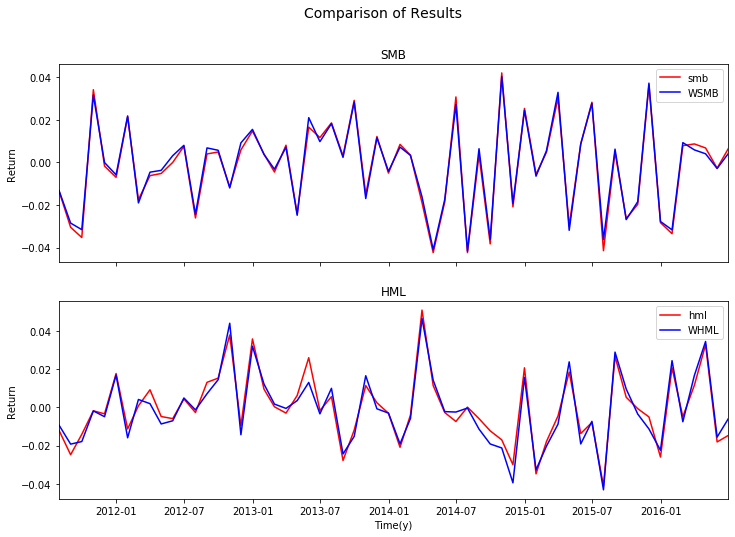

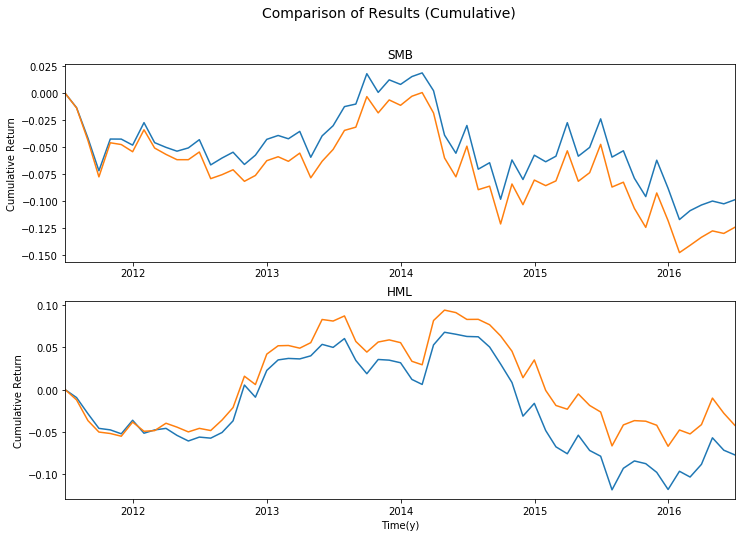

In [9]:
###################
# Compare With FF #
###################
from scipy import stats
_ff = conn.get_table(library='ff', table='factors_monthly')
_ff=_ff[['date','smb','hml']]
_ff['date']=_ff['date']+MonthEnd(0)

_ffcomptep = pd.merge(_ff, ff_factors_size[['date','WSMB']], how='inner', on=['date'])
_ffcomp = pd.merge(_ffcomptep, ff_factors_hml[['date','WHML']], how='inner', on=['date'])

_ffcomp70=_ffcomp
print("The pearson coefficients between replication and fama-french official factors")
# print(stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']))
# print(stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML']))

#Print out the above result in a formal way
mydata=[stats.pearsonr(_ffcomp70['smb'], _ffcomp70['WSMB']),stats.pearsonr(_ffcomp70['hml'], _ffcomp70['WHML'])]
a=DataFrame(mydata, index=['SMB','HML'], columns=['correlation coefficient','p value'])
print(a)

###################
# Visualization of comparison #
###################
#You may wanna change the data range in the future for case by case use
psyear=dt.datetime.strptime(crspvalid,"%m/%d/%Y").year
psmonth=dt.datetime.strptime(crspvalid,"%m/%d/%Y").month

peyear=dt.datetime.strptime(crspend,"%m/%d/%Y").year
pemonth=dt.datetime.strptime(crspend,"%m/%d/%Y").month
pday=dt.datetime.strptime(crspend,"%m/%d/%Y").day

pdf1=plt.figure(figsize=(12,8)) 
plt.suptitle("Comparison of Results", fontsize=14)
ax1=plt.subplot(2, 1, 1)
plt.ylabel("Return")
plt.title("SMB")
plt.plot(_ffcomp70['date'],_ffcomp70['smb'],label = 'smb',color='red')
plt.plot(_ffcomp70['date'],_ffcomp70['WSMB'], label = 'WSMB',color='blue')
plt.legend(loc="best")
ax1.set_xlim([dt.date(psyear, psmonth, pday), dt.date(peyear, pemonth, pday)])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2=plt.subplot(2, 1, 2)
plt.xlabel('Time(y)')
plt.ylabel("Return")
plt.title("HML")
plt.plot(_ffcomp70['date'],_ffcomp70['hml'],label = 'hml', color='red')
plt.plot(_ffcomp70['date'],_ffcomp70['WHML'],label = 'WHML', color='blue')
ax2.set_xlim([dt.date(psyear, psmonth, pday), dt.date(peyear, pemonth, pday)])
plt.legend(loc="best")
plt.show()

#further inspection on cumulative returns
pdf2=plt.figure(figsize=(12,8)) 
plt.suptitle("Comparison of Results (Cumulative)", fontsize=14)

ax1=plt.subplot(2, 1, 1)
_ffcomp60smb=_ffcomp70[['date','smb','WSMB']]
_ffcomp60smb.set_index(["date"], inplace=True)
plt.ylabel("Cumulative Return")
plt.title("SMB")
# Inserting zero row at the first position  
data = []
data.insert(0, {'smb': 0,  'WSMB': 0})
_ffcomp60smb=pd.concat([pd.DataFrame(data, index=[dt.date(psyear, psmonth-1, pday)]), _ffcomp60smb], sort=True)
cumsmb=(_ffcomp60smb + 1).cumprod() - 1


plt.plot(cumsmb)
#plt.legend(loc="best")
ax1.set_xlim([dt.date(psyear, psmonth-1, pday), dt.date(peyear, pemonth, pday)])

ax2=plt.subplot(2, 1, 2)
_ffcomp60hml=_ffcomp70[['date','hml','WHML']]
_ffcomp60hml.set_index(["date"], inplace=True)
plt.xlabel('Time(y)')
plt.ylabel("Cumulative Return")
plt.title("HML")
#plt.legend(loc="best")

# Inserting zero row at the first position  
data = []
data.insert(0, {'hml': 0,  'WHML': 0})
_ffcomp60hml=pd.concat([pd.DataFrame(data, index=[dt.date(psyear, psmonth-1, pday)]), _ffcomp60hml], sort=True)
cumhml=(_ffcomp60hml + 1).cumprod() - 1

plt.plot(cumhml) 
ax2.set_xlim([dt.date(psyear, psmonth-1, pday), dt.date(peyear, pemonth, pday)])

#Save pdf
pdfout=f'FF_Model_HML_{crspvalid[-4:]}_{crspend[-4:]}.pdf'
pp = PdfPages(pdfout)
pp.savefig(pdf1)
pp.savefig(pdf2)
pp.close()

# ###################
# # output data #
# ###################
dataout=f'FF_Model_{crspvalid[-4:]}_{crspend[-4:]}.xlsx'
writer = pd.ExcelWriter(dataout, engine='xlsxwriter')
ff_factors_size.to_excel(writer,sheet_name='ff_factors_size') 
ff_factors_hml.to_excel(writer,sheet_name='ff_hml') 
nyse_bm.to_excel(writer,sheet_name='nyse_bm') 
nyse_sz.to_excel(writer,sheet_name='nyse_sz') 
writer.save()


###################
# Key reflections on the construction #
###################
#Q1: What is our sample pool?
#Q2: How often do we renew the portfolio?
#Q3: What databases are used?
#Q4: How to define the criteria for size and value?
# Basically this program updates its portfolio on a yearly base. From July at year-t to June at year-t+1, it can calculate the monthly value-weighted return of each portfolio and eventually give us factors we need. Benchmark for classification is NYSE's Me in June and Beme in December last year. 